In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import OrderedDict

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import utils, models


# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
from nltk.corpus import stopwords
import string
from bs4 import BeautifulSoup
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
warnings.filterwarnings('ignore')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/scottbchrist/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/scottbchrist/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/scottbchrist/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#code to clean text
stop = set(stopwords.words('english'))
exclude =set(string.punctuation)
useless_words = ['would','could','should','le','non','federal','way','hour','lack','make','lot','getting','use','believe','thing']
for word in useless_words:
    stop.add(word)

## Set up dataframe

In [51]:
data = pd.read_excel('data.xlsx')

df = data[['AGENCY','COMPONENT','SUB_COMPONENT','GRADELEVEL','SUP_STATUS','Please briefly describe an example of one burdensome administrative task or process which you believe is "low value"']]
df.columns = ['AGENCY','COMPONENT','SUB_COMPONENT','GRADELEVEL','SUP_STATUS','TEXT']

In [74]:
full_df = df[df['TEXT'].isnull()==False]
full_df = df[df['TEXT'].isna()==False]

In [75]:
full_df = df[df['COMPONENT'].isna()==False]

In [76]:
full_df = df[df['GRADELEVEL'].isna()==False]

In [77]:
full_df.dropna(subset=['TEXT'],inplace=True)

In [78]:
#df_ag = full_df[full_df['AGENCY']=='Department of Agriculture']


In [79]:
#data_ag = df_ag['TEXT'].values.tolist()

In [80]:
full_df.fillna('other')
full_df.replace(pd.isna,'other')

,AGENCY,COMPONENT,SUB_COMPONENT,GRADELEVEL,SUP_STATUS,TEXT
3,Department of Agriculture,"Cooperative State Research, Education, and Ext...",NaN,GS-1,0,surveys
5,Department of Agriculture,"Cooperative State Research, Education, and Ext...",NaN,GS-11,0,"I am not an administrator, some of these quest..."
6,Department of Agriculture,"Cooperative State Research, Education, and Ext...",NaN,GS-11,0,Our systems are slow. We've been put in a buil...
7,Department of Agriculture,"Cooperative State Research, Education, and Ext...",NaN,GS-13,0,Due to lack of IT video teleconference support...
11,Department of Agriculture,"Cooperative State Research, Education, and Ext...",NaN,GS-7,0,Fruit fly tech do not need computers to do tra...
...,...,...,...,...,...,...
243511,Social Security Administration,Other,NaN,SES,0,A good example is this survey. The servers lo...
243512,Social Security Administration,Other,NaN,SES,0,Working in office instead of by telework
243515,Social Security Administration,Other,NaN,SES,1,Watching VOD's that do not relate to productio...
243517,Social Security Administration,Other,NaN,SL,1,The current process of SSI couples presents a ...


In [12]:
unique_comps = full_df['COMPONENT'].unique()
unique_agenics = full_df['AGENCY'].unique()

## Remove emails and newline characters

In [36]:
'''# Remove Emails
data_ag = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data_ag]

# Remove new line characters
data_ag = [re.sub('\s+', ' ', str(sent)) for sent in data_ag]

# Remove distracting single quotes
data_ag = [re.sub("\'", "", str(sent)) for sent in data_ag]'''

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#data_ag_words = list(sent_to_words(data_ag))

In [38]:
print(data_ag_words[:2])

[['surveys'], ['am', 'not', 'an', 'administrator', 'some', 'of', 'these', 'questions', 'should', 'have', 'na', 'option']]


## Build bigram and trigrams

In [39]:
'''# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_ag_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_ag_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)'''

In [40]:
print(trigram_mod[bigram_mod[data_ag_words[12]]])

['administrative', 'work', 'of', 'entering', 'information', 'in', 'multiple', 'spreadsheets', 'or', 'databases', 'there', 'is', 'not', 'enough', 'money', 'to', 'pay', 'for', 'single', 'system', 'that', 'can', 'track', 'what', 'we', 'enter', 'in', 'multiple', 'locations', 'management', 'doesnt', 'seem', 'to', 'understand', 'the', 'need', 'for', 'single', 'system', 'nor', 'the', 'concept', 'of', 'putting', 'money', 'out', 'now', 'that', 'in', 'return', 'will', 'benefit', 'the', 'office', 'in', 'the', 'long', 'run']


## Remove Stopwords, make Bigrams and lemmatize

In [26]:
nlp = spacy.load('en', disable=['parser', 'ner'])


In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','none'])

In [43]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_ag_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



In [44]:
print(data_lemmatized[:3])

[['survey'], ['administrator', 'question', 'option'], ['system', 'slow', 'have', 'put', 'build', 'horrible', 'internet', 'service', 'agency', 'constantly', 'work', 'system', 'change', 'well']]


## create dictionary and corpus

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [46]:
print(corpus[:2])

[[(0, 1)], [(1, 1), (2, 1), (3, 1)]]


## Find optimal number of topics

In [30]:
#moved to utils

In [48]:
#model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=2)


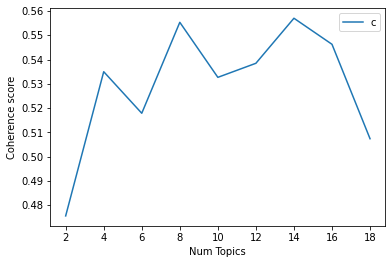

In [49]:
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [170]:
#moved to  calc


[0.33033811430465687, 0.3927841082133433, 0.40157153606341806, 0.40027017558810607, 0.3809462951695882, 0.36753437461311605, 0.38553986526480527, 0.38097159991571616, 0.3761438386528182]
6
[(0,
  '0.044*"system" + 0.028*"work" + 0.026*"time" + 0.015*"information" + '
  '0.013*"need" + 0.012*"computer" + 0.012*"datum" + 0.012*"report"'),
 (1,
  '0.052*"time" + 0.026*"file" + 0.023*"none" + 0.014*"work" + 0.012*"hour" + '
  '0.011*"office" + 0.009*"form" + 0.009*"day"'),
 (2,
  '0.022*"information" + 0.013*"enter" + 0.013*"system" + 0.013*"time" + '
  '0.012*"need" + 0.012*"email" + 0.012*"employee" + 0.011*"datum"'),
 (3,
  '0.040*"report" + 0.019*"work" + 0.017*"meeting" + 0.015*"survey" + '
  '0.015*"answer" + 0.011*"training" + 0.010*"level" + 0.010*"activity"'),
 (4,
  '0.021*"document" + 0.021*"time" + 0.014*"work" + 0.014*"file" + '
  '0.014*"vehicle" + 0.013*"task" + 0.013*"system" + 0.012*"require"'),
 (5,
  '0.018*"time" + 0.018*"work" + 0.018*"process" + 0.013*"take" + 0.010*"

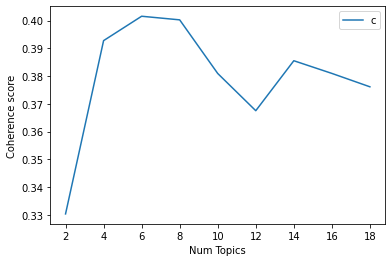

In [171]:
print_model(full_df[(full_df['AGENCY']=='Department of Justice') & (full_df['SUP_STATUS']==1)])

[0.40009340891186285, 0.4478372111161547, 0.4260066533453546, 0.45138224051296993, 0.451557256459915, 0.43674124066761305, 0.4267827069134067, 0.39268656340811214, 0.4192548031318366]
10
[(0,
  '0.023*"training" + 0.018*"require" + 0.016*"system" + 0.016*"complete" + '
  '0.015*"form" + 0.012*"need" + 0.011*"request" + 0.011*"entry"'),
 (1,
  '0.057*"file" + 0.034*"none" + 0.026*"paper" + 0.023*"document" + '
  '0.019*"time" + 0.016*"form" + 0.016*"electronic" + 0.015*"work"'),
 (2,
  '0.026*"document" + 0.017*"management" + 0.015*"form" + 0.014*"time" + '
  '0.012*"require" + 0.012*"email" + 0.009*"system" + 0.009*"take"'),
 (3,
  '0.055*"report" + 0.055*"meeting" + 0.015*"many" + 0.012*"conference" + '
  '0.012*"review" + 0.012*"project" + 0.011*"weekly" + 0.010*"keep"'),
 (4,
  '0.022*"email" + 0.020*"system" + 0.018*"process" + 0.018*"survey" + '
  '0.017*"training" + 0.016*"hire" + 0.015*"datum" + 0.015*"employee"'),
 (5,
  '0.049*"time" + 0.037*"work" + 0.013*"task" + 0.013*"empl

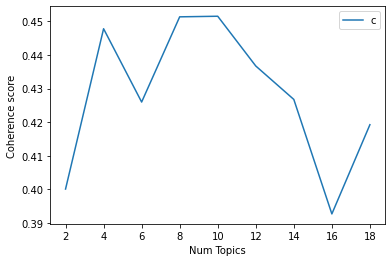

In [172]:
print_model(full_df[full_df['AGENCY']=='Department of Justice'])

In [18]:
scores = {'Department of Agriculture':{
'scores':{'total':8,'manager':4,'nonmanager':8
}},
'Department of Commerce':{
'scores':{'total':6,'manager':4,'nonmanager':6
}},
'Department of Defense':{
'scores':{'total':10,'manager':16,'nonmanager':8
}},
'Department of Education':{
'scores':{'total':6,'manager':14,'nonmanager':8
}},
'Department of Energy':{
'scores':{'total':4,'manager':18,'nonmanager':6
}},
'Department of Health and Human Services':{
'scores':{'total':6,'manager':10,'nonmanager':10
}},
'Department of Homeland Security':{
'scores':{'total':6,'manager':6,'nonmanager':6
}},
'Department of Housing and Urban Development':{
'scores':{'total':4,'manager':10,'nonmanager':4
}},
'Department of Justice':{
'scores':{'total':8,'manager':12,'nonmanager':4
}},
'Department of Labor':{
'scores':{'total':8,'manager':14,'nonmanager':6
}},
'Department of State':{
'scores':{'total':14,'manager':6,'nonmanager':6
}},
'Department of the Interior':{
'scores':{'total':10,'manager':14,'nonmanager':4
}},
'Department of the Treasury':{
'scores':{'total':8,'manager':10,'nonmanager':8
}},
'Department of Transportation':{
'scores':{'total':6,'manager':16,'nonmanager':6
}},
'Department of Veterans Affairs':{
'scores':{'total':8,'manager':12,'nonmanager':6
}},
'Environmental Protection Agency':{
'scores':{'total':14,'manager':12,'nonmanager':10
}},
'General Services Administration':{
'scores':{'total':18,'manager':8,'nonmanager':6
}},
'National Aeronautics and Space Administration':{
'scores':{'total':4,'manager':18,'nonmanager':6
}},
'National Science Foundation':{
'scores':{'total':4,'manager':16,'nonmanager':12
}},
'Nuclear Regulatory Commission':{
'scores':{'total':6,'manager':16,'nonmanager':6
}},
'Office of Personnel Management':{
'scores':{'total':6,'manager':12,'nonmanager':6
}},
'Social Security Administration':{
'scores':{'total':10,'manager':6,'nonmanager':6
}},
'Small Business Administration':{
'scores':{'total':6,'manager':16,'nonmanager':6
}},
'U.S. Agency for International Development':{
'scores':{'total':4,'manager':12,'nonmanager':8
}
}}

In [19]:
scores.keys()

dict_keys(['Department of Agriculture', 'Department of Commerce', 'Department of Defense', 'Department of Education', 'Department of Energy', 'Department of Health and Human Services', 'Department of Homeland Security', 'Department of Housing and Urban Development', 'Department of Justice', 'Department of Labor', 'Department of State', 'Department of the Interior', 'Department of the Treasury', 'Department of Transportation', 'Department of Veterans Affairs', 'Environmental Protection Agency', 'General Services Administration', 'National Aeronautics and Space Administration', 'National Science Foundation', 'Nuclear Regulatory Commission', 'Office of Personnel Management', 'Social Security Administration', 'Small Business Administration', 'U.S. Agency for International Development'])

# Get Topics for agency level data

In [44]:
def get_topics_agencies(df,topic_num):
    data_2 = df['TEXT'].values.tolist()

    # Remove Emails
    data_2 = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data_2]

    # Remove new line characters
    data_2 = [re.sub('\s+', ' ', str(sent)) for sent in data_2]

    # Remove distracting single quotes
    data_2 = [re.sub("\'", "", str(sent)) for sent in data_2]

    data_words_2 = list(sent_to_words(data_2))

    # Build the bigram and trigram models
    bigram2 = gensim.models.Phrases(data_words_2, min_count=5, threshold=50) # higher threshold fewer phrases.
    trigram2 = gensim.models.Phrases(bigram2[data_words_2], threshold=50)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
    trigram_mod2= gensim.models.phrases.Phraser(trigram2)

    # Remove Stop Words
    data_words_nostops2 = remove_stopwords(data_words_2)

    # Form Bigrams
    data_words_bigrams2 = make_bigrams(data_words_nostops2,bigram_mod2)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized2 = lemmatization(data_words_bigrams2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word2 = corpora.Dictionary(data_lemmatized2)

    # Create Corpus
    texts2 = data_lemmatized2

    # Term Document Frequency
    corpus2 = [id2word2.doc2bow(text) for text in texts2]

    #model_list, coherence_values = compute_coherence_values(dictionary=id2word2, corpus=corpus2, texts=data_lemmatized2, start=2, limit=20, step=2)

    #print(coherence_values)
    #max_coherence_score = max(coherence_values)
    #best_num_loc = coherence_values.index(max_coherence_score)
    #best_topic_num = (coherence_values.index(max_coherence_score) + 1) *2
    #print (best_topic_num)

    #best_model = model_list[best_num_loc]

    #model_topics = best_model.show_topics(formatted=False)

    model_2 = gensim.models.ldamodel.LdaModel( corpus=corpus2, num_topics=topic_num, id2word=id2word2)

    #pprint(best_model.print_topics(num_words=8))
    #pprint(model_2.print_topics(num_words=8))

    return model_2.show_topics(num_words=8,formatted=True)


In [97]:
def get_topics(df):


    data_2 = df['TEXT'].values.tolist()
    if len(data_2)==0:
        return 'empty'

    # Remove Emails
    data_2 = [re.sub('\S*@\S*\s?', '', str(sent)) for sent in data_2]

    # Remove new line characters
    data_2 = [re.sub('\s+', ' ', str(sent)) for sent in data_2]

    # Remove distracting single quotes
    data_2 = [re.sub("\'", "", str(sent)) for sent in data_2]

    data_words_2 = list(sent_to_words(data_2))

    # Build the bigram and trigram models
    bigram2 = gensim.models.Phrases(data_words_2, min_count=5, threshold=50) # higher threshold fewer phrases.
    trigram2 = gensim.models.Phrases(bigram2[data_words_2], threshold=50)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod2 = gensim.models.phrases.Phraser(bigram2)
    trigram_mod2= gensim.models.phrases.Phraser(trigram2)

    # Remove Stop Words
    data_words_nostops2 = remove_stopwords(data_words_2)

    # Form Bigrams
    data_words_bigrams2 = make_bigrams(data_words_nostops2,bigram_mod2)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized2 = lemmatization(data_words_bigrams2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word2 = corpora.Dictionary(data_lemmatized2)

    # Create Corpus
    texts2 = data_lemmatized2

    # Term Document Frequency
    corpus2 = [id2word2.doc2bow(text) for text in texts2]
    try:
        model_list, coherence_values = compute_coherence_values(dictionary=id2word2, corpus=corpus2, texts=data_lemmatized2, start=2, limit=20,\
                   step=2,id2word=id2word2)
    except ValueError:
        return 'no data'

    #print(coherence_values)
    max_coherence_score = max(coherence_values)
    best_num_loc = coherence_values.index(max_coherence_score)
    best_topic_num = (coherence_values.index(max_coherence_score) + 1) *2
    #print (best_topic_num)

    #best_model = model_list[best_num_loc]

    #model_topics = best_model.show_topics(formatted=False)

    model_2 = gensim.models.ldamodel.LdaModel( corpus=corpus2, num_topics=best_topic_num, id2word=id2word2)

    #pprint(best_model.print_topics(num_words=8))
    #pprint(model_2.print_topics(num_words=8))

    return model_2.show_topics(num_words=8,formatted=True)

In [45]:
topic_dict_agency={}
key_values = ['total', 'manager', 'nonmanager']

for agency in unique_agenics:
    topic_dict_agency[agency] = get_topics_agencies(full_df[full_df['AGENCY']==agency],scores.get(agency).get('scores').get('total'))


In [47]:
agency_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in topic_dict_agency.items() ])).T
agency_df.to_csv('Agency_Topics.csv')

In [48]:
topic_dict_agency_mang={}
key_values = ['total', 'manager', 'nonmanager']

for agency in unique_agenics:
    topic_dict_agency_mang[agency] = get_topics_agencies(full_df[(full_df['AGENCY']==agency) & (full_df['SUP_STATUS']==1)],scores.get(agency).get('scores').get('manager'))

In [50]:
agency_df_mang = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in topic_dict_agency_mang.items() ])).T
agency_df_mang.to_csv('Agency_Topics_Senior_Manager.csv')

In [51]:
topic_dict_agency_nonmang={}
key_values = ['total', 'manager', 'nonmanager']

for agency in unique_agenics:
    topic_dict_agency_nonmang[agency] = get_topics_agencies(full_df[(full_df['AGENCY']==agency) & (full_df['SUP_STATUS']==0)],scores.get(agency).get('scores').get('nonmanager'))

In [52]:
agency_df_nonmang = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in topic_dict_agency_nonmang.items() ])).T
agency_df_nonmang.to_csv('Agency_Non_Manager_Topics.csv')

In [35]:
unique_grades = full_df['GRADELEVEL'].unique()
grade_topic_dict = {}
for grade in unique_grades:
    grade_topic_dict[grade] = get_topics(full_df[full_df['GRADELEVEL']==grade])

In [39]:
gs_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in grade_topic_dict.items() ])).T
gs_df.to_csv('GS_Topics.csv')

In [117]:
unique_comps_topics_mang = {}

for agency in unique_agenics:
    temp_dict = {}

    for comps in full_df[(full_df['AGENCY']==agency) & (full_df['SUP_STATUS']==1)]['COMPONENT'].unique():
        temp_dict[comps] = get_topics(full_df[(full_df['AGENCY']==agency) & (full_df['SUP_STATUS']==1)&(full_df['COMPONENT']==comps)])
    
    unique_comps_topics_mang[agency] = temp_dict

    

In [187]:
comps_mang_df = pd.DataFrame([(k,k1,pd.Series(v1)) for k,v in unique_comps_topics_mang.items() for k1,v1 in v.items() ],columns=['Agency','Component','topics'])

In [188]:
headers_list = ['Agency','Component','topics','topic 0','topic 1','topic 2', 'topic 3','topic 4','topic 5','topic 6','topic 7', 'topic 8','topic 9']
comps_mang_df = comps_mang_df.reindex(columns = headers_list)

In [194]:
for i in range(len(comps_mang_df)):
    for t in range((10)):
        try:
            comps_mang_df['topic '+str(t)].iloc[i] = comps_mang_df['topics'].iloc[i][t][1]
        except KeyError:
            pass


In [196]:
comps_mang_df.to_csv('Component_SR_Manager.csv')

In [198]:
unique_comps_topics_nonmang = {}

for agency in unique_agenics:
    temp_dict = {}

    for comps in full_df[(full_df['AGENCY']==agency) & (full_df['SUP_STATUS']==0)]['COMPONENT'].unique():
        temp_dict[comps] = get_topics(full_df[(full_df['AGENCY']==agency) & (full_df['SUP_STATUS']==0)&(full_df['COMPONENT']==comps)])
    
    unique_comps_topics_nonmang[agency] = temp_dict

In [199]:
comps_nonmang_df = pd.DataFrame([(k,k1,pd.Series(v1)) for k,v in unique_comps_topics_nonmang.items() for k1,v1 in v.items() ],columns=['Agency','Component','topics'])
headers_list = ['Agency','Component','topics','topic 0','topic 1','topic 2', 'topic 3','topic 4','topic 5','topic 6','topic 7', 'topic 8','topic 9']
comps_nonmang_df = comps_nonmang_df.reindex(columns = headers_list)
for i in range(len(comps_nonmang_df)):
    for t in range((10)):
        try:
            comps_nonmang_df['topic '+str(t)].iloc[i] = comps_nonmang_df['topics'].iloc[i][t][1]
        except KeyError:
            pass


In [200]:
comps_nonmang_df.to_csv('Component_Non_Manager.csv')

In [201]:
unique_comps_topics = {}

for agency in unique_agenics:
    temp_dict = {}

    for comps in full_df[(full_df['AGENCY']==agency)]['COMPONENT'].unique():
        temp_dict[comps] = get_topics(full_df[(full_df['AGENCY']==agency)&(full_df['COMPONENT']==comps)])
    
    unique_comps_topics[agency] = temp_dict

In [202]:
comps_df = pd.DataFrame([(k,k1,pd.Series(v1)) for k,v in unique_comps_topics.items() for k1,v1 in v.items() ],columns=['Agency','Component','topics'])
headers_list = ['Agency','Component','topics','topic 0','topic 1','topic 2', 'topic 3','topic 4','topic 5','topic 6','topic 7', 'topic 8','topic 9']
comps_df = comps_df.reindex(columns = headers_list)
for i in range(len(comps_df)):
    for t in range((10)):
        try:
            comps_df['topic '+str(t)].iloc[i] = comps_df['topics'].iloc[i][t][1]
        except KeyError:
            pass

In [203]:
comps_df.to_csv('Component_Topics.csv')

In [27]:
f = open('GS_Topics.csv','r')


In [29]:
f_text = f.read()
list1=re.sub(r"[^a-zA-Z]+", ' ',f_text)
g

In [32]:
f.close()

In [36]:
g = open('Agency_Topics.csv','r')
g_text = g.read()
listg=re.sub(r"[^a-zA-Z]+", ' ',g_text)
g.close()

In [40]:
h = open('Component_SR_manager.csv','r')
h_text = h.read()
listh=re.sub(r"[^a-zA-Z]+", ' ',h_text)
h.close()

In [41]:
j = open('Component_Topics.csv','r')
j_text = j.read()
listj=re.sub(r"[^a-zA-Z]+", ' ',j_text)
j.close()

In [42]:
k = open('Component_Topics.csv','r')
k_text = k.read()
listk=re.sub(r"[^a-zA-Z]+", ' ',k_text)
k.close()

In [43]:
l = open('Agency_Topics_Senior_Manager.csv','r')
l_text = l.read()
listl=re.sub(r"[^a-zA-Z]+", ' ',l_text)
l.close()

In [48]:
new_word = listl+listk+listj+listh+listg+list1

In [50]:
text_file = open('words.txt',"w")
text_file.write(new_word)
text_file.close()